In [1]:
import sys
sys.path.append("/home/alex/Desktop/Research/MasterProject/codes/classifiers/PointNet")
import argparse
import torch
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
from dataset.nuScenes import NuScenesData
from model.pointnet import PointNetCls
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np 
import sklearn.metrics as metrics
import random

random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [2]:
classes = {'human.pedestrian.adult': 0,
            # 'human.pedestrian.child': 0, void class
            'human.pedestrian.wheelchair': 0,
            'human.pedestrian.stroller': 0,
            'human.pedestrian.personal_mobility': 0,
            'human.pedestrian.police_officer': 0,
            'human.pedestrian.construction_worker': 0,
            'vehicle.car': 1,
            # 'vehicle.emergency.ambulance': 1, void class
            'vehicle.emergency.police': 1,
            'vehicle.motorcycle': 2,
            'vehicle.bicycle': 2,
            'vehicle.bus.bendy': 3,
            'vehicle.bus.rigid': 3,
            'vehicle.truck': 4,
            'vehicle.construction': 5,
            'vehicle.trailer': 6,
            'movable_object.barrier': 7,
            'movable_object.trafficcone': 7,
            'movable_object.pushable_pullable': 7,
            'movable_object.debris': 7,
            # 'animal': 10, void class
            'static_object.bicycle_rack': 8,
        }

In [3]:
model_path = '/home/alex/Desktop/Research/MasterProject/codes/classifiers/PointNet/weights/cls_6/cls_model_79.pth'
batch_size = 256
test_dataset = NuScenesData(root_dir = '/home/alex/Desktop/Research/MasterProject/codes/data/real/test_pointclouds',points = 2048)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
label = [1,4,7,6,3,5,0,2,8]

In [4]:
classifier = PointNetCls(k=len(test_dataset.classes), feature_transform = False)
classifier = classifier.cuda()
classifier.load_state_dict(torch.load(model_path))
classifier = classifier.eval()

In [5]:
test_pred = []
test_true = []
for points, target in test_dataloader:
    points, target = points.cuda(), target.cuda()
    pred, _, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]
    test_true.append(target.cpu().numpy())
    test_pred.append(pred_choice.detach().cpu().numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)

In [6]:
test_acc = metrics.accuracy_score(test_true, test_pred)
avg_precision = metrics.precision_score(test_true, test_pred, average = 'macro')
avg_recall = metrics.recall_score(test_true, test_pred,average = 'macro')
avg_f1 = metrics.f1_score(test_true, test_pred,average = 'macro')
outstr = 'Test :: test acc: %.6f, test avg precision: %.6f , test avg recall: %.6f, test avg f1: %.6f' % (test_acc, avg_precision, avg_recall, avg_f1)

In [7]:
outstr

'Test :: test acc: 0.921806, test avg precision: 0.821828 , test avg recall: 0.839891, test avg f1: 0.822949'

In [8]:
f1 = metrics.f1_score(test_true, test_pred,labels = label, average = None)

In [9]:
metrics.f1_score(test_true, test_pred,labels = label, average = 'macro')

0.7769975068452806

In [10]:
f1

array([0.95229818, 0.70141414, 0.98490566, 0.86567164, 0.70886076,
       0.5631769 , 0.92035398, 0.55555556, 0.74074074])

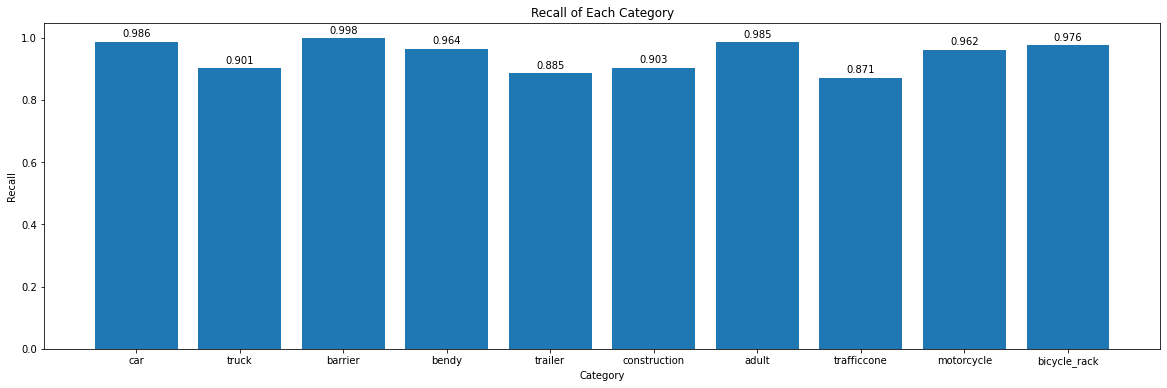

In [12]:
plt.figure(figsize=(20, 6))
plt.bar(labels, Recall)
plt.xticks(labels)
plt.xlabel("Category")
plt.ylabel("Recall")
plt.title("Recall of Each Category")

for a,b in zip(labels, Recall):
    plt.text(a,b+0.01,'%.3f'%b,ha = 'center',va = 'bottom',fontsize=10)


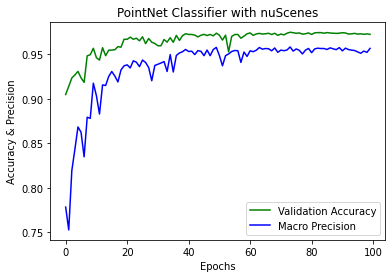

In [17]:
epochs = range(100)
plt.plot(epochs,accuracy_list,'g',label='Validation Accuracy')
plt.plot(epochs,precision_list,'b',label='Macro Precision')
plt.title('PointNet Classifier with nuScenes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy & Precision')
plt.legend()
plt.show()

In [9]:
torch.save(precision_list, "precision_100_epochs.pt")